### Assignment 1 Deep Learning and Sensor fusion 2026

Multi class Classification

### Necessary iomport here

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import Dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import random

print(f"[INFO] Torch infos: {torch.__version__}")

DATASET_PATH = os.path.join("..", "Dataset", "BoneBreakClassification")

[INFO] Torch infos: 2.10.0+cpu


In [9]:
# some helpers
def load_data(dataset_path, class_names, type_of_data_to_load):
    # for each class name
    images, labels = list(), list()
    for el in class_names.keys():
        print(f"[WALKING] Walking into {el}")
        for images_name in os.listdir(os.path.join(dataset_path, el, type_of_data_to_load)):
            full_image_path = os.path.join(dataset_path, el, type_of_data_to_load, images_name)
            images.append(full_image_path)
            labels.append(class_names[el])
    return images, labels

# set Dataset path
The path yopu see in the code point to my folder

```
.
├── Assignment_1
│   ├── Assignment_1_four_layers.ipynb
│   ├── Assignment_1_template.ipynb
│   ├── Assignment_1_three_layers.ipynb
│   └── cnn_ass_1.pt
├── Dataset
│   ├── BoneBreakClassification

```

If you put the data in a different place change it.

In [10]:
DATASET_PATH = os.path.join(".", "BoneBreakClassification")

### (1) Load dataset

In [11]:
class_names = dict()

temp = os.listdir(DATASET_PATH)
temp = sorted(temp)

# prep up list and class number together
for i in range(len(temp)):
    class_names[temp[i]] = i

train_data_handler, train_labels_handler = load_data(dataset_path=DATASET_PATH,
                                                       class_names=class_names,
                                                       type_of_data_to_load="Train")

# load test data
test_data_to_split, test_labels_to_split = load_data(dataset_path=DATASET_PATH,
                                                   class_names=class_names,
                                                   type_of_data_to_load="Test")

#Combine Test and Validation Data and Shuffle Them
combined = list(zip(test_data_to_split, test_labels_to_split))
random.shuffle(combined)

test_data_to_split, test_labels_to_split = zip(*combined)
test_data_to_split = list(test_data_to_split)
test_labels_to_split = list(test_labels_to_split)

[WALKING] Walking into Avulsion fracture
[WALKING] Walking into Comminuted fracture
[WALKING] Walking into Fracture Dislocation
[WALKING] Walking into Greenstick fracture
[WALKING] Walking into Hairline Fracture
[WALKING] Walking into Impacted fracture
[WALKING] Walking into Longitudinal fracture
[WALKING] Walking into Oblique fracture
[WALKING] Walking into Pathological fracture
[WALKING] Walking into Spiral Fracture
[WALKING] Walking into Avulsion fracture
[WALKING] Walking into Comminuted fracture
[WALKING] Walking into Fracture Dislocation
[WALKING] Walking into Greenstick fracture
[WALKING] Walking into Hairline Fracture
[WALKING] Walking into Impacted fracture
[WALKING] Walking into Longitudinal fracture
[WALKING] Walking into Oblique fracture
[WALKING] Walking into Pathological fracture
[WALKING] Walking into Spiral Fracture


# (2) leave this cell because we need to create a val dataset and it is not there as default

In [12]:
# let s create validation we do not have
val_ratio = 0.2
val_size = int(len(test_data_to_split) * val_ratio)
test_size = len(test_data_to_split) - val_size

test_data_handler = test_data_to_split[:test_size]
test_labels_handler = test_labels_to_split[:test_size]

validation_data_handler = test_data_to_split[test_size:]
validation_labels_handler = test_labels_to_split[test_size:]

print(f"[TRAIN DATA LOADED] Data loaded complete {len(train_data_handler)} Labeles are {len(train_labels_handler)}")
print(f"[VALIDATION DATA LOADED] Data loaded complete {len(validation_data_handler)} Labeles are {len(validation_labels_handler)}")
print(f"[TEST DATA LOADED] Data loaded complete {len(test_data_handler)} Labeles are {len(test_labels_handler)}")

[TRAIN DATA LOADED] Data loaded complete 989 Labeles are 989
[VALIDATION DATA LOADED] Data loaded complete 28 Labeles are 28
[TEST DATA LOADED] Data loaded complete 112 Labeles are 112


### (3) Here ate two transforms one for training and one for evaluation

train transform need data augmentation:
- add random flip
- add random rotation
- add color jitter

both need need:
- resize
- toTensor handler
- Normalize (use the provided MEAN and STD)

Note that the evaluation transform does not need data augmentation.

In [13]:
TARGET_H = 224
TARGET_W = 224
IMAGE_MEAN = [0.485,0.456,0.406]
IMAGE_STD = [0.229,0.224,0.225]

# create transform
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  #Add a Random Horizontal Flip With %50 Chance of Flipping
    transforms.RandomRotation(20),  #Rotate Image by 20 Degrees With A Random Chance
    transforms.ColorJitter(0.2,0.15, 0.25, 0.075),  #Change the Colors of the Image a Bit by Random Amounts
    transforms.Resize((TARGET_H, TARGET_W)),    #Resize Image to 224X224
    transforms.ToTensor(),  #Convert to Tensor
    transforms.Normalize(IMAGE_MEAN, IMAGE_STD) #Normalize the Image With Given Mean and STD. Dev.
])

#Same as Above, Except We Don't Apply Flip, Rotation and Color Changes
evaluation_transform = transforms.Compose([
    transforms.Resize((TARGET_H, TARGET_W)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGE_MEAN, IMAGE_STD)
])

In [14]:
class MyDataset(Dataset):
    def __init__(self, list_of_pathes, list_of_classes, transform=None) -> None:
        super().__init__()
        self.list_of_pathes = list_of_pathes
        self.list_of_classes = list_of_classes
        self.transform = transform

    def __len__(self):
        return len(self.list_of_pathes)

    def __getitem__(self, index):
        # select the image at index
        imgPath = self.list_of_pathes[index]
        # select the label at index
        label = self.list_of_classes[index]
        # open the image Advice use Image package
        img =  Image.open(imgPath)
        # apply transform
        if self.transform != None:
            image_as_tensor = self.transform(img)
        else:
            print("No transform provided!")
        # return image and label
        return image_as_tensor, label

### (4) Create data loder from the MyDataset class

In [15]:
train_dataset = MyDataset(list_of_pathes=train_data_handler,
                          list_of_classes=train_labels_handler,
                          transform=train_transform)

validation_dataset = MyDataset(list_of_pathes=validation_data_handler,
                                list_of_classes=validation_labels_handler,
                                transform=evaluation_transform)

test_dataset = MyDataset(list_of_pathes=test_data_handler,
                          list_of_classes=test_labels_handler,
                          transform=evaluation_transform)

# put those here
#Batch Sizes For Loaders Were Chosen as 32 and Shuffling Was Turned On For Training Data
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### Instance of the CNN
Use the Sequential API it is faster
- This cnn has two hidden layers (conv2d -> proper activation -> max pool 2d)  one has 16 untis and the second has 32 units
- Add a flatten layer
- Classifier need 128 Linear unit proper activation and set dropdown at 0.5
- The last layer of the classifier how many units need?


In [ ]:
#The Class Code Was Taken From the Lecture Slides
class CNNClass(nn.Module):
    def __init__(self, outputClasses, kernelSize, paddingSize, poolingSize, inputChannels, dropoutRate, denseUnits, layersList):
        super().__init__()

        layers = []
        inputUnits = inputChannels  #The Input Color Channels to CNN

        #Add CNN Layers According to Layer Numbers Specified
        for units in layersList:    #For each Layer We Add a Convolution, ReLU and Pooling Layer
            layers += [
                nn.Conv2d(in_channels=inputUnits, out_channels= units, kernel_size=kernelSize, padding=paddingSize),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=poolingSize)
            ]
            inputUnits = units  #Update Input Size to Next Layer

        self.features = nn.Sequential(*layers)  #Create CNN Layers

        FCLayers = []
        #The New Image Sizes Since Pooling Changes the Size of the Images
        newImageHeight = TARGET_H // (poolingSize ** len(layersList))
        newImageWidth = TARGET_W // (poolingSize ** len(layersList))
        inputToFC = layersList[-1] * newImageHeight * newImageWidth
        for units in denseUnits:    #The Fully Connected Layers Except Last One, Each FC Layer consists of a linear layer, relu and a dropout operation.
            FCLayers += [
                nn.Linear(inputToFC, units),
                nn.ReLU(),
                nn.Dropout(dropoutRate)
            ]
            inputUnits = units

        self.classifier = nn.Sequential(*FCLayers)

        self.flattenLayer = nn.Flatten()    #Flatten Layer
        self.finalClassifier = nn.Linear(inputUnits, outputClasses)  #The Final Classifier

    def forward(self, x):   #The Function that Allows the cnn layers to flow through as we want
        x = self.features(x)
        x = self.flattenLayer(x)
        x = self.classifier(x)
        x = self.finalClassifier(x)
        return x

simpleCNNParams = { #Create the parameters for the simple cnn
    "outputClasses" : 10,
    "kernelSize" : 3,
    "paddingSize" : 1,
    "poolingSize" : 2,
    "inputChannels" : 3,
    "dropoutRate" : 0.2,
    "denseUnits" : [256],
    "layersList" : [32, 64]
}
simpleCNN = CNNClass(**simpleCNNParams)

### (5) Add proper optimizer and loss function set training epochs to 50

In [17]:
lossFunc = nn.CrossEntropyLoss()    #Use Cross-entropy loss as the loss function
optimizerFunc = optim.Adam(simpleCNN.parameters(), lr = 1e-3, weight_decay=1e-5)    #Use Adam Optimizer function to tweak the weights
epochNum = 50   #Set number of epochs to 50

# (6) add here the train and evaluation loop collect loss and accuracy, we want to see curves here

In [18]:
#Training Function
#This Function Was Taken From Lecture Slides
def trainOneEpoch(model, loader, lossFunc, optimizer, device):
    model.train()   #Set cnn to training mode
    runningLoss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:   #Go through each image in test loader
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()   #Zero the gradients from before

        logits = model(images)  #Run images through the model
        loss  = lossFunc(logits, labels)    #Calculate loss with the loss function

        loss.backward() #Calculate the gradients

        optimizer.step()    #Adjust the weights with the optimizer function

        #Adjust the loss, correct and total number of instances
        runningLoss += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return runningLoss / total, correct / total #Return avg loss and avg correctness (accuracy)

#Evaluation Function

@torch.no_grad()
def evaluate(model, loader, lossFunc, device):
    model.eval()    #Set cnn to evaluation mode
    #Variable initialization
    correct = 0
    total = 0
    runningLoss = 0.0

    for image, label in loader: #Go through evaluation dataseet
        image = image.to(device)
        label = label.to(device)

        logits = model(image)   #Make predictions
        #Calculate loss
        loss = lossFunc(logits, label) 
        currentLoss = loss.item()

        #Update loss, correct and total variables
        runningLoss += currentLoss * image.size(0)
        prediction = logits.argmax(dim=1)
        correct += (prediction == label).sum().item()
        total += label.size(0)
    return runningLoss / total, correct / total #Return avg loss and accuracy


#Initialization
lossesTraining = []
accuraciesTraining = []
lossesEval = []
accuraciesEval = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   #Use GPU if available else cpu
model = simpleCNN.to(device)    #Move the cnn to the selected device
bestValAcc = 0.0    #The best accuracy
#Training Loop
for epoch in range(1,epochNum+1):
    #Train the model and get loss and accuracies
    avgLoss, accuracy = trainOneEpoch(model=model, loader=train_dataloader, lossFunc=lossFunc, optimizer=optimizerFunc, device=device)  #Train an Epoch
    #Save Values to Arrays
    lossesTraining.append(avgLoss)
    accuraciesTraining.append(accuracy)
    if epoch % 2 == 0:  #Evaluate Once Every 2 Epochs
        avgLoss, accuracy = evaluate(model=model,loader=validation_dataloader,lossFunc=lossFunc,device=device)
        #Save Values to Arrays
        lossesEval.append(avgLoss)
        accuraciesEval.append(accuracy)
        #Check If an Accuracy Better Than Max Value Was Seen
        if accuracy > bestValAcc:
            bestValAcc = accuracy
            torch.save(simpleCNN.state_dict(), "bestWeigths.pt")    #Save the Parameters If They Exceed the Best Ones That Were Ever Seen

    print("Epoch " + str(epoch) + " is done.")  #Print at end of each epoch
print("Training Is Done. The Best Eval Accuracy Is: " + str(bestValAcc))


Epoch 1 is done.
Epoch 2 is done.
Epoch 3 is done.
Epoch 4 is done.
Epoch 5 is done.
Epoch 6 is done.
Epoch 7 is done.
Epoch 8 is done.
Epoch 9 is done.
Epoch 10 is done.
Epoch 11 is done.
Epoch 12 is done.
Epoch 13 is done.
Epoch 14 is done.
Epoch 15 is done.
Epoch 16 is done.
Epoch 17 is done.
Epoch 18 is done.
Epoch 19 is done.
Epoch 20 is done.
Epoch 21 is done.
Epoch 22 is done.
Epoch 23 is done.
Epoch 24 is done.
Epoch 25 is done.
Epoch 26 is done.
Epoch 27 is done.
Epoch 28 is done.
Epoch 29 is done.
Epoch 30 is done.
Epoch 31 is done.
Epoch 32 is done.
Epoch 33 is done.
Epoch 34 is done.
Epoch 35 is done.
Epoch 36 is done.
Epoch 37 is done.
Epoch 38 is done.
Epoch 39 is done.
Epoch 40 is done.
Epoch 41 is done.
Epoch 42 is done.
Epoch 43 is done.
Epoch 44 is done.
Epoch 45 is done.
Epoch 46 is done.
Epoch 47 is done.
Epoch 48 is done.
Epoch 49 is done.
Epoch 50 is done.
Training Is Done. The Best Eval Accuracy Is: 0.4642857142857143


### 6.2)The Plotting is Done Here

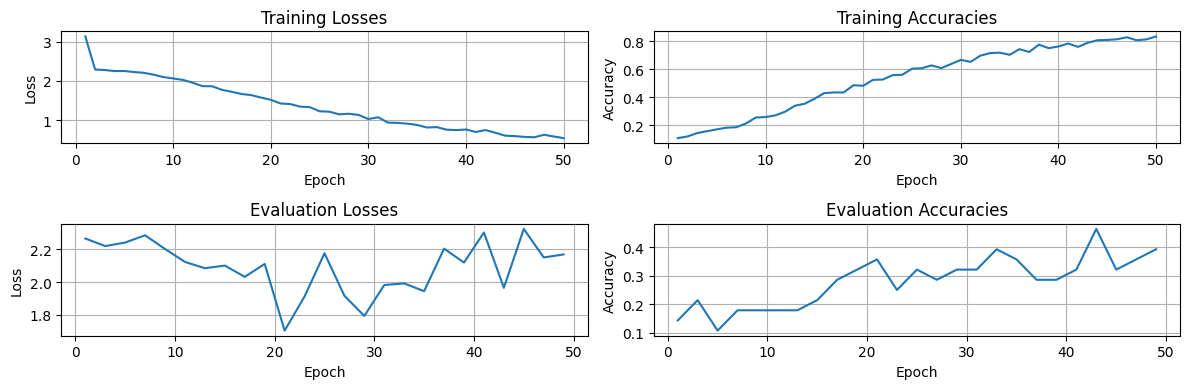

In [19]:
#Plotting The Loss and Accuracies
fig, axs = plt.subplots(2, 2, figsize=(12, 4))  #Create 4 subplots

ax1, ax2 = axs[0]
ax3, ax4 = axs[1]

#For  each subplot, plot corresponding values against epoch number and set things like axis labels and title
ax1.plot(range(1, epochNum+1), lossesTraining)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Losses')
ax1.grid(True)

ax2.plot(range(1, epochNum+1), accuraciesTraining)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracies')
ax2.grid(True)

ax3.plot(range(1, epochNum+1, 2), lossesEval)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.set_title('Evaluation Losses')
ax3.grid(True)

ax4.plot(range(1, epochNum+1, 2), accuraciesEval)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy')
ax4.set_title('Evaluation Accuracies')
ax4.grid(True)

plt.tight_layout()
plt.show()

# (7) Make prediction and shows some predicted images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..1.7859696].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781512..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9602616].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7859696].
Clipp

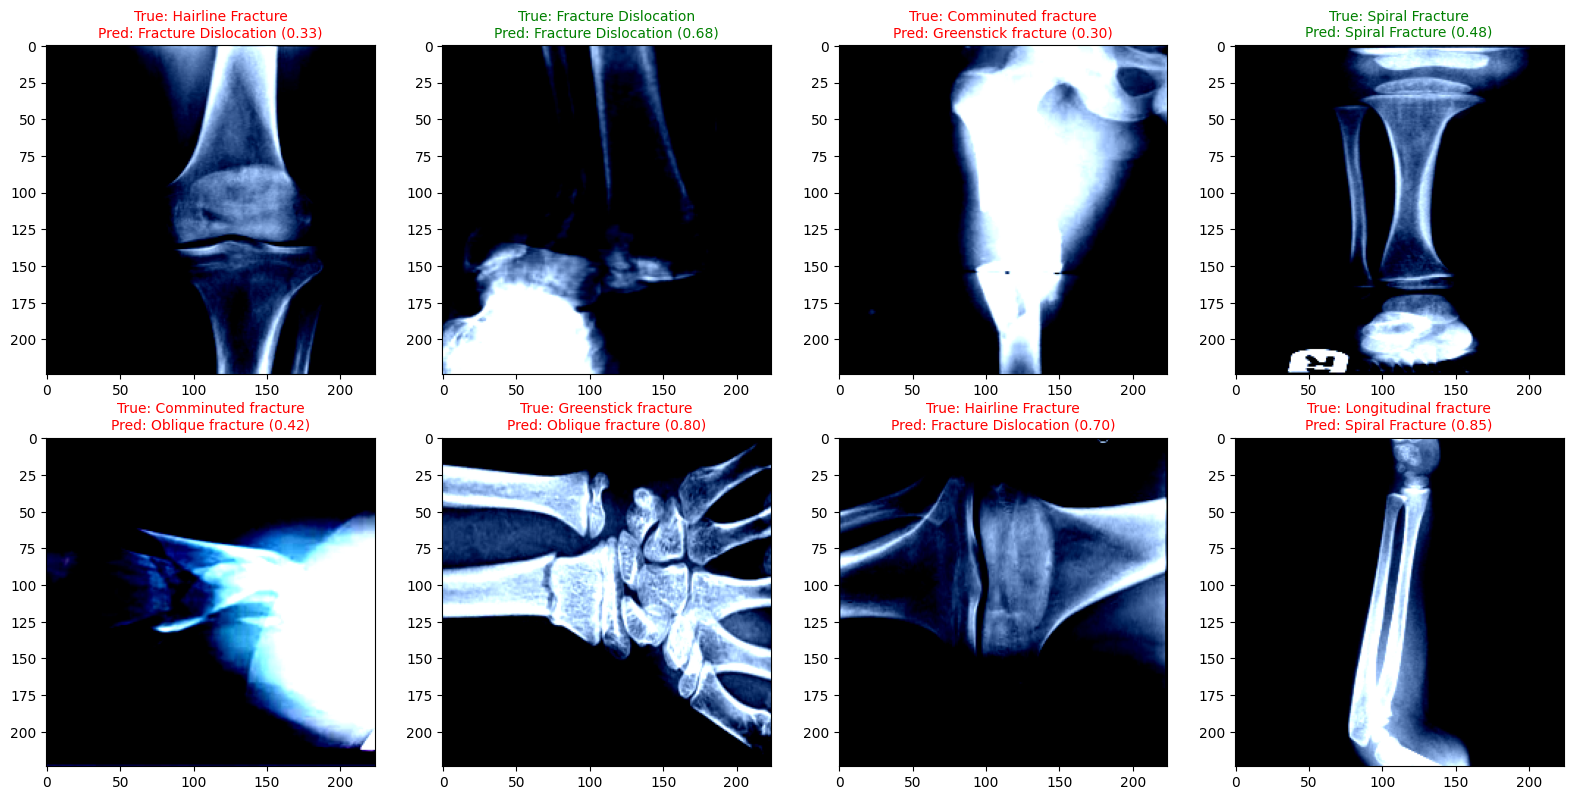

In [20]:
@torch.no_grad()
#This function was taken from the lecture slides
def predictBatch(model, images, device, classNames=None, topk=1):
    model.eval()    #Set model to evaluation mode
    images = images.to(device)

    logits = model(images)  #Make predictions
    probs = F.softmax(logits, dim=1)    #Use the softmax function to calculate the probabilites of each prediction

    topProbs, topIdxs = probs.topk(topk, dim=1) #Take the top k preds

    results = []
    #Create a list of results with a dict for each guess containing label, idx and probability
    for i in range(images.size(0)):
        preds = []
        for k in range(topk):
            idx = int(topIdxs[i, k].item())
            p = float(topProbs[i, k].item())
            label = classNames[idx] if classNames else idx
            preds.append({"label": label, "index": idx, "prob": p})
        results.append({"topk": preds})
    return results

#Create the CNN With Pre-trained Parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simpleCNN = CNNClass(**simpleCNNParams)
model = simpleCNN.to(device=device)
checkpoints = torch.load("bestWeigths.pt", map_location="cpu")
simpleCNN.load_state_dict(checkpoints)

#Invert the class_names Dictionary so Keys Become Numbers and Values Become the Fracture Type. The Code Was Taken From an Online Source
# Source - https://stackoverflow.com/a/483833
# Posted by SilentGhost, modified by community. See post 'Timeline' for change history
# Retrieved 2026-01-31, License - CC BY-SA 4.0

inv_class_names = {v: k for k, v in class_names.items()}


# Get one batch from test dataloader
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# Make Predictions
predictions = predictBatch(model, images, device, classNames=inv_class_names, topk=3)

# Visualize First 8 Images With Predictions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

#Visualizing Images
for i in range(8):
    # Get Prediction
    top_pred = predictions[i]["topk"][0]
    pred_label = top_pred["label"]
    pred_prob = top_pred["prob"]

    # Get True Label
    true_label = inv_class_names[labels[i].item()]

    # Plot the Images
    axes[i].imshow(images[i].permute(1,2,0))

    # Show Text as Green If Correct, Else Red
    color = 'green' if pred_label == true_label else 'red'
    axes[i].set_title(f"True: {true_label}\nPred: {pred_label} ({pred_prob:.2f})",
                      color=color, fontsize=10)

plt.tight_layout()
plt.show()

# (8) Make Evaluation with confusion matrix

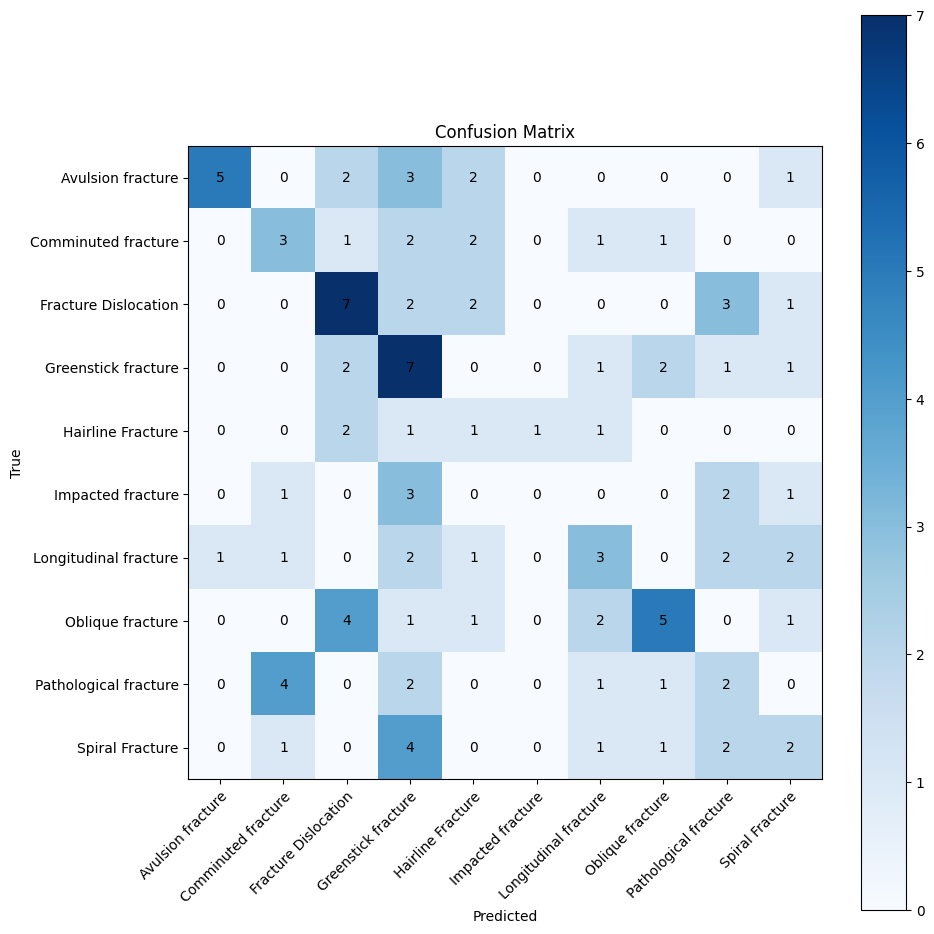

In [21]:
#Tests the Model on the Test Dataset and Returns All Predicted and Real Class Indexes
def testModel(model, loader, device):
    #These arrays contain the value for each image on test set of real and predicted labels
    realArr = []
    predictedArr = []
    for images, labels in loader:   #Predict on entire test set
        results = predictBatch(model, images, device, inv_class_names)
        labels = labels.numpy().tolist()
        realArr.extend(labels)
        for result in results:
            result = list(list(result.values())[0][0].values())
            predictedArr.append(result[1])
    return np.array(predictedArr), np.array(realArr)

predArr, realArr = testModel(model, test_dataloader, device)

cm = confusion_matrix(realArr, predArr) #Create the Confusion Matrix

class_labels = [inv_class_names[i] for i in range(len(inv_class_names))]    #Get Class Labels In Order

#Plot the confusion matrix using matplotlib
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, cmap="Blues")

#Set the labels for the matrix
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)

#Rotate the labels below so they don't overlap
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

# Write Counts In Each Cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]), ha="center", va="center", color="black")

fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

### Instance of a new CNN
Use the Sequential API it is faster
- This cnn has tre hidden layers (conv2d -> proper activation -> max pool 2d)  one has 16 untis, the second has 32 units, and the third has 64
- Add a flatten layer
- Classifier need 128 Linear unit proper activation and set dropdown at 0.5
- The last layer of the classifier how many units need?

Repeat from 5 to 8

### (5.1) Set Parameters and create CNN

In [22]:
complexCNNParams = {
    "outputClasses" : 10,
    "kernelSize" : 3,
    "paddingSize" : 1,
    "poolingSize" : 2,
    "inputChannels" : 3,
    "dropoutRate" : 0.2,
    "denseUnits" : [256],
    "layersList" : [32, 64, 128]
}
complexCNN = CNNClass(**complexCNNParams)

### (5) Add proper optimizer and loss function set training epochs to 50

In [23]:
lossFunc = nn.CrossEntropyLoss()
optimizerFunc = optim.Adam(complexCNN.parameters(), lr = 1e-3, weight_decay=1e-5)
epochNum = 50

# (6) add here the train and evaluation loop collect loss and accuracy, we want to see curves here

In [24]:
lossesTraining = []
accuraciesTraining = []
lossesEval = []
accuraciesEval = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = complexCNN.to(device)
bestValAcc = 0.0
#Training Loop
for epoch in range(1,epochNum+1):
    avgLoss, accuracy = trainOneEpoch(model=model, loader=train_dataloader, lossFunc=lossFunc, optimizer=optimizerFunc, device=device)  #Train an Epoch
    #Save Values to Arrays
    lossesTraining.append(avgLoss)
    accuraciesTraining.append(accuracy)
    if epoch % 2 == 0:  #Evaluate Once Every 2 Epochs
        avgLoss, accuracy = evaluate(model=model,loader=validation_dataloader,lossFunc=lossFunc,device=device)
        #Save Values to Arrays
        lossesEval.append(avgLoss)
        accuraciesEval.append(accuracy)
        #Check If an Accuracy Better Than Max Value Was Seen
        if accuracy > bestValAcc:
            bestValAcc = accuracy
            torch.save(complexCNN.state_dict(), "bestWeigthsComplexModel.pt")    #Save the Parameters If They Exceed the Best Ones That Were Ever Seen

    print("Epoch " + str(epoch) + " is done.")
print("Training Is Done. The Best Eval Accuracy Is: " + str(bestValAcc))


Epoch 1 is done.
Epoch 2 is done.
Epoch 3 is done.
Epoch 4 is done.
Epoch 5 is done.
Epoch 6 is done.
Epoch 7 is done.
Epoch 8 is done.
Epoch 9 is done.
Epoch 10 is done.
Epoch 11 is done.
Epoch 12 is done.
Epoch 13 is done.
Epoch 14 is done.
Epoch 15 is done.
Epoch 16 is done.
Epoch 17 is done.
Epoch 18 is done.
Epoch 19 is done.
Epoch 20 is done.
Epoch 21 is done.
Epoch 22 is done.
Epoch 23 is done.
Epoch 24 is done.
Epoch 25 is done.
Epoch 26 is done.
Epoch 27 is done.
Epoch 28 is done.
Epoch 29 is done.
Epoch 30 is done.
Epoch 31 is done.
Epoch 32 is done.
Epoch 33 is done.
Epoch 34 is done.
Epoch 35 is done.
Epoch 36 is done.
Epoch 37 is done.
Epoch 38 is done.
Epoch 39 is done.
Epoch 40 is done.
Epoch 41 is done.
Epoch 42 is done.
Epoch 43 is done.
Epoch 44 is done.
Epoch 45 is done.
Epoch 46 is done.
Epoch 47 is done.
Epoch 48 is done.
Epoch 49 is done.
Epoch 50 is done.
Training Is Done. The Best Eval Accuracy Is: 0.5


### 6.2)The Plotting is Done Here

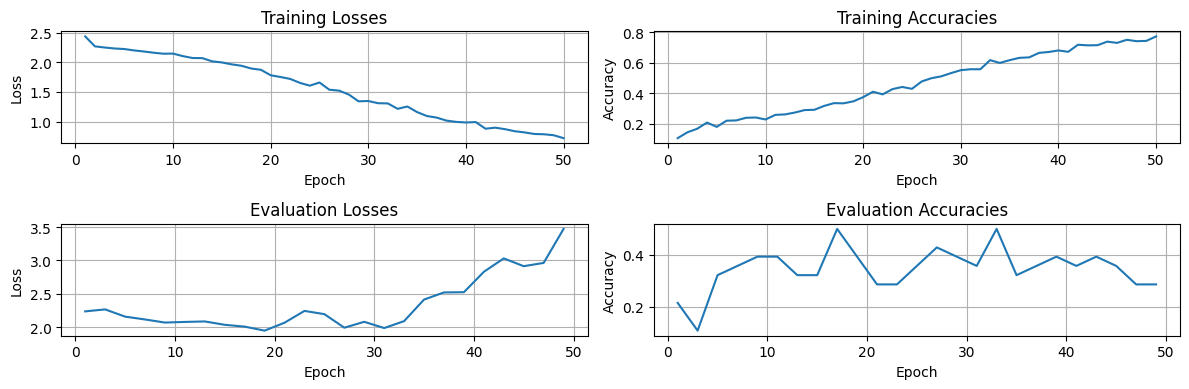

In [25]:
#Plotting The Loss and Accuracies
fig, axs = plt.subplots(2, 2, figsize=(12, 4))

ax1, ax2 = axs[0]
ax3, ax4 = axs[1]

ax1.plot(range(1, epochNum+1), lossesTraining)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Losses')
ax1.grid(True)

ax2.plot(range(1, epochNum+1), accuraciesTraining)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracies')
ax2.grid(True)

ax3.plot(range(1, epochNum+1, 2), lossesEval)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.set_title('Evaluation Losses')
ax3.grid(True)

ax4.plot(range(1, epochNum+1, 2), accuraciesEval)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy')
ax4.set_title('Evaluation Accuracies')
ax4.grid(True)

plt.tight_layout()
plt.show()

# (7) Make prediction and shows some predicted images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..1.7859696].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781512..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9602616].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7859696].
Clipp

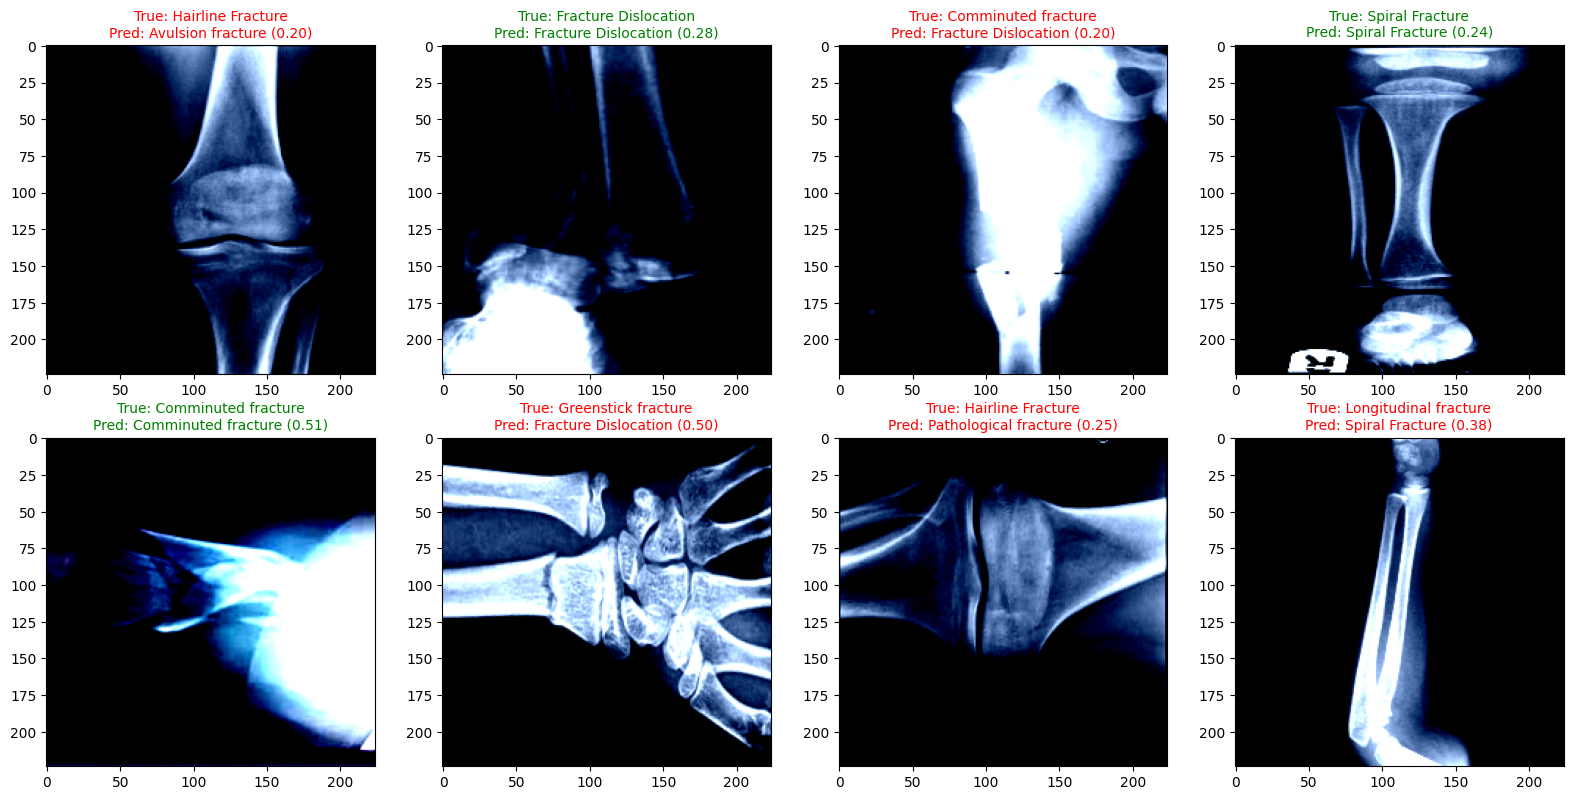

In [26]:
#Create the CNN With Pre-trained Parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
complexCNN = CNNClass(**complexCNNParams)
model = complexCNN.to(device=device)
checkpoints = torch.load("bestWeigthsComplexModel.pt", map_location="cpu")
complexCNN.load_state_dict(checkpoints)

#Invert the class_names Dictionary so Keys Become Numbers and Values Become the Fracture Type. The Code Was Taken From an Online Source
# Source - https://stackoverflow.com/a/483833
# Posted by SilentGhost, modified by community. See post 'Timeline' for change history
# Retrieved 2026-01-31, License - CC BY-SA 4.0

inv_class_names = {v: k for k, v in class_names.items()}


# Get one batch from test dataloader
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# Make Predictions
predictions = predictBatch(model, images, device, classNames=inv_class_names, topk=3)

# Visualize First 8 Images With Predictions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

#Visualizing Images
for i in range(8):
    # Get Prediction
    top_pred = predictions[i]["topk"][0]
    pred_label = top_pred["label"]
    pred_prob = top_pred["prob"]

    # Get True Label
    true_label = inv_class_names[labels[i].item()]

    # Plot the Images
    axes[i].imshow(images[i].permute(1,2,0))

    # Show Text as Green If Correct, Else Red
    color = 'green' if pred_label == true_label else 'red'
    axes[i].set_title(f"True: {true_label}\nPred: {pred_label} ({pred_prob:.2f})",
                      color=color, fontsize=10)

plt.tight_layout()
plt.show()

# (8) Make Evaluation with confusion matrix

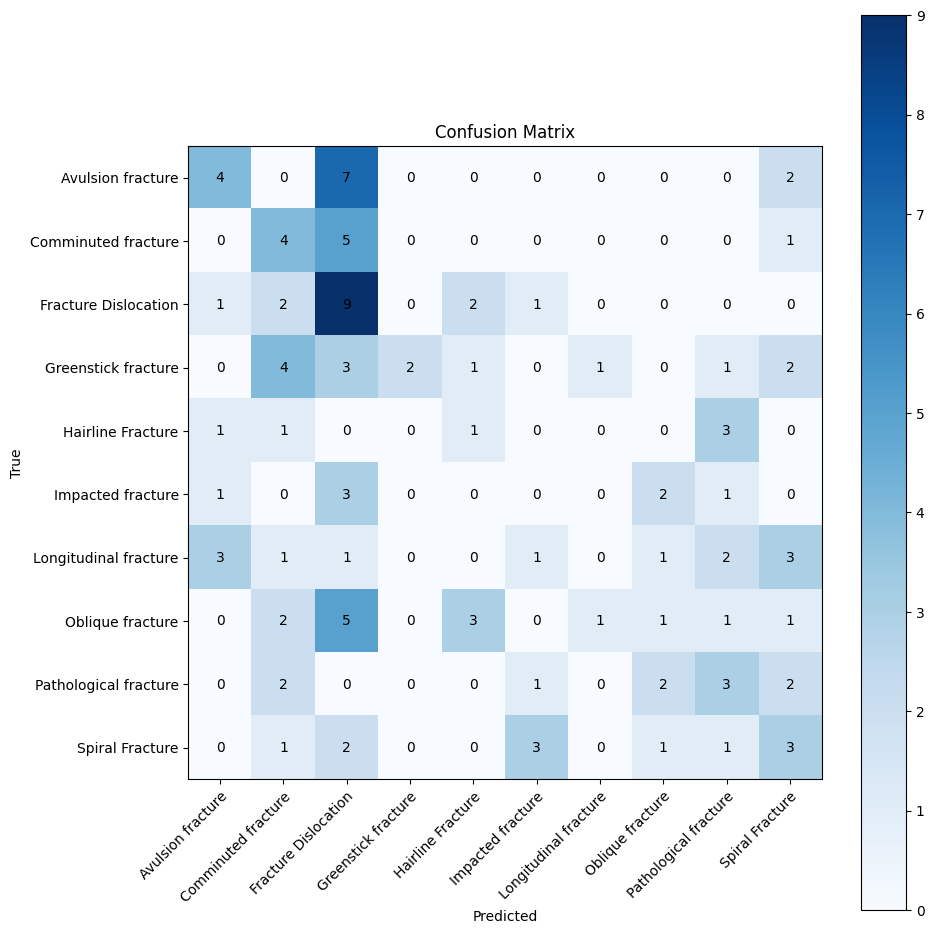

In [27]:
#Tests the Model on the Test Dataset and Returns All Predicted and Real Class Indexes
#The comments aren't written here since this is the same as code at the first cnn
def testModel(model, loader, device):
    realArr = []
    predictedArr = []
    for images, labels in loader:
        results = predictBatch(model, images, device, inv_class_names)
        labels = labels.numpy().tolist()
        realArr.extend(labels)
        for result in results:
            result = list(list(result.values())[0][0].values())
            predictedArr.append(result[1])
    return np.array(predictedArr), np.array(realArr)

predArr, realArr = testModel(model, test_dataloader, device)

cm = confusion_matrix(realArr, predArr) #Create the Confusion Matrix

class_labels = [inv_class_names[i] for i in range(len(inv_class_names))]    #Get Class Labels In Order

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, cmap="Blues")

ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

# Write Counts In Each Cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]), ha="center", va="center", color="black")

fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()